<a href="https://colab.research.google.com/github/HsuJieRu/hw2/blob/main/bonus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
import torchvision
from torchvision.datasets import MNIST

dataset = MNIST('/content/',download=True, train=True)
#dataset = MNIST('/content/drive/MyDrive/', train=True)

print("Dataset length:",len(dataset))
print("Image Info:", dataset[0])

Dataset length: 60000
Image Info: (<PIL.Image.Image image mode=L size=28x28 at 0x7F30D52CBA30>, 5)


Ground truth label: 5


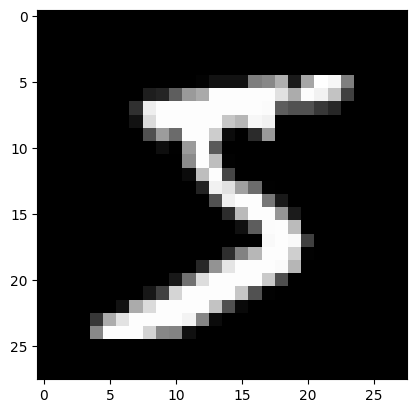

In [14]:
import matplotlib.pyplot as plt

image, label = dataset[0]
plt.imshow(image, cmap='gray')
print("Ground truth label:", label)

Image shape: torch.Size([1, 28, 28])
Label: 3


tensor([[0.0000, 0.0000, 0.0000, 0.0941, 0.8196],
        [0.0000, 0.0000, 0.3569, 0.5373, 0.9922],
        [0.1569, 0.8392, 0.9804, 0.9961, 0.9961],
        [0.3176, 0.9686, 0.9961, 0.9961, 0.9961],
        [0.0000, 0.4314, 0.9647, 0.9961, 0.9961]])

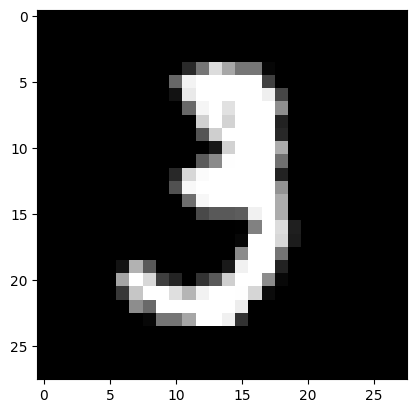

In [15]:
import torchvision.transforms as transforms
dataset = MNIST('/content/', train=True, transform=transforms.ToTensor())

img_tensor, label = dataset[10]
print("Image shape:", img_tensor.shape)
plt.imshow(img_tensor[0], cmap='gray')
print("Label:", label)
img_tensor[0,10:15,10:15]


In [16]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(dataset,[40000,20000])
print("Training dataset length: ",len(train_ds))
print("Validating dataset length: ",len(val_ds))

Training dataset length:  40000
Validating dataset length:  20000


Testing dataset length:  10000
Image label: 9


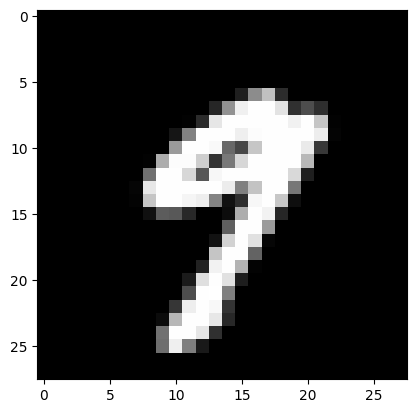

In [17]:
test_ds = MNIST('/content/', train=False, transform=transforms.ToTensor())
print("Testing dataset length: ",len(test_ds))
img_tensor, label = test_ds[20]
plt.imshow(img_tensor[0], cmap='gray')
print("Image label:",label)

Batch image shape: torch.Size([128, 1, 28, 28])
Batch label shape: torch.Size([128])
Image label: tensor(7)


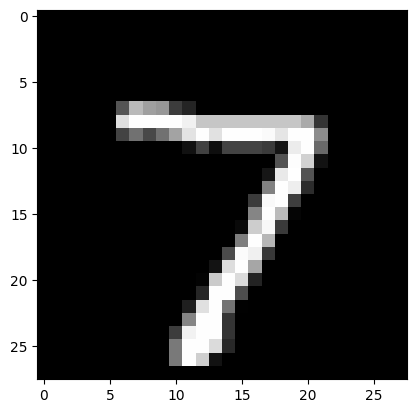

In [18]:
from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size)

for images, labels in test_loader:
  print("Batch image shape:", images.shape)
  print("Batch label shape:", labels.shape)
  plt.imshow(images[0,0], cmap='gray')
  print("Image label:",labels[0])
  break

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

input_size = 28*28
hidden_size = 1000
num_classes = 10

class FocalLoss(nn.modules.loss._WeightedLoss):
  def __init__(self, weight=None, gamma=2, reduction='mean'):
    super(FocalLoss, self).__init__(weight, reduction=reduction)
    self.gamma = gamma
    self.weight = weight
  def forward(self, input, target):
    ce_loss = F.cross_entropy(input, target, reduction=self.reduction, weight = self.weight)
    pt = torch.exp(-ce_loss)
    focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
    return focal_loss


class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
              nn.Linear(input_size, hidden_size),
              #nn.ReLU(),
              nn.Linear(hidden_size, num_classes))

  def forward(self,xb):
    xb = xb.reshape(-1,input_size)
    out = self.network(xb)
    return out

  def training_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = FocalLoss()(out, labels)
    return loss, out.detach(), labels.detach() #梯度反傳的時候只更新B中參數的值，而不更新A中的參數值，
  
  def accuracy(self, outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(labels)) 
  
  def validation_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = self.accuracy(out, labels)
    data = [labels, out]
    return {'val_loss': loss, 'val_acc': acc, 'data':data}
  
  def validation_average(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  
  def evaluate(self,val_loader):
    outputs = [self.validation_step(batch) for batch in val_loader]
    data = [output['data'] for output in outputs]
    return self.validation_average(outputs), data

  def print_out(self,epoch,result):
    print("Epoch [{}], val_loss: {:.6f}, val_acc: {:.6f}".format(epoch, result['val_loss'], result['val_acc']))

  def print_all(self,epoch,result):
    print("Epoch [{}], train_loss: {:.6f}, train_acc: {:.6f}, val_loss: {:.6f}, val_acc: {:.6f}".format(epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))


In [20]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  history = []

  for epoch in range(epochs):
    for batch in train_loader:
      loss, out, label = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      acc = model.accuracy(out, label)
    test_result,_ = model.evaluate(val_loader)
    test_result['train_loss'] = loss.item()
    test_result['train_acc'] = acc.numpy()
    model.print_all(epoch, test_result)
    history.append(test_result)
  return history

In [21]:
epoch = 20
lr = 0.001
model = MnistModel()
optimizer = torch.optim.SGD #主要為了優化我們的神經網絡，使神經網絡在我們的訓練過程中快起來，節省時間。在pytorch中提供了torch.optim方法優化我們的神經網絡
import time
t1 = time.perf_counter()
history1 = fit(epoch, lr, model, train_loader, val_loader, opt_func = optimizer)
t2 = time.perf_counter()
print("Time taken for training without GPU: {:.2f}".format(t2-t1))


Epoch [0], train_loss: 1.521987, train_acc: 0.546875, val_loss: 2.032368, val_acc: 0.606837
Epoch [1], train_loss: 1.257292, train_acc: 0.671875, val_loss: 1.791288, val_acc: 0.742138
Epoch [2], train_loss: 0.995833, train_acc: 0.765625, val_loss: 1.585340, val_acc: 0.772442
Epoch [3], train_loss: 0.782783, train_acc: 0.750000, val_loss: 1.414200, val_acc: 0.786574
Epoch [4], train_loss: 0.681753, train_acc: 0.843750, val_loss: 1.275802, val_acc: 0.795880
Epoch [5], train_loss: 0.634404, train_acc: 0.812500, val_loss: 1.165488, val_acc: 0.804389
Epoch [6], train_loss: 0.445421, train_acc: 0.812500, val_loss: 1.077655, val_acc: 0.811604
Epoch [7], train_loss: 0.414039, train_acc: 0.750000, val_loss: 1.007004, val_acc: 0.816829
Epoch [8], train_loss: 0.440421, train_acc: 0.828125, val_loss: 0.949379, val_acc: 0.822353
Epoch [9], train_loss: 0.352595, train_acc: 0.781250, val_loss: 0.901670, val_acc: 0.827428
Epoch [10], train_loss: 0.245090, train_acc: 0.843750, val_loss: 0.861643, val_a

Text(0.5, 1.0, 'Loss vs number of epochs')

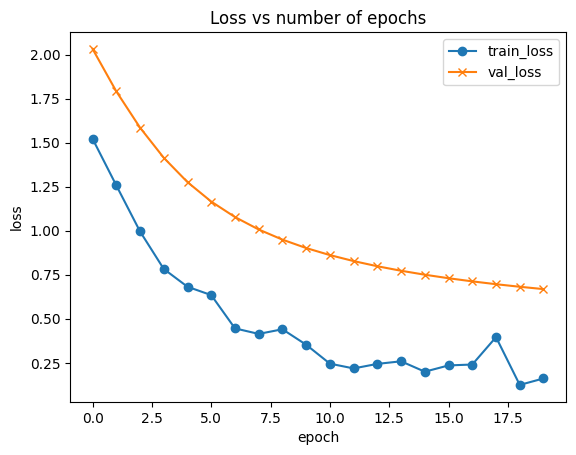

In [22]:
train_loss = [result['train_loss'] for result in history1]
val_loss = [result['val_loss'] for result in history1]
plt.plot(train_loss, '-o', label="train_loss")
plt.plot(val_loss, '-x', label="val_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs number of epochs')

Text(0.5, 1.0, 'Accuracy vs number of epochs')

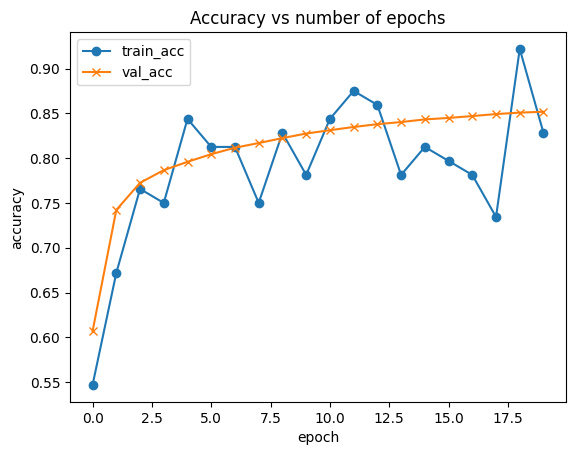

In [23]:
train_acc = [result['train_acc'] for result in history1]
val_acc = [result['val_acc'] for result in history1]
plt.plot(train_acc, '-o', label="train_acc")
plt.plot(val_acc, '-x', label="val_acc")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy vs number of epochs')

In [24]:
result,_ = model.evaluate(test_loader)
result['test_loss'] = result.pop('val_loss')
result['test_acc'] = result.pop('val_acc')
print("Performance",result)

Performance {'test_loss': 0.6489948034286499, 'test_acc': 0.8579905033111572}
